# Tutorial for the *CYCLUS* Fuel Cycle Simulator

[*CYCLUS*](http://fuelcycle.org/) is an open soruce fuel cycle simulator.  It is agent-based, and its user-customizable archetypes (called <font color='800000'>prototypes</font>) allow for more freedom in the fidelity, depth, and focus of the simulation.
<br><br>
This tutorial will begin with a simple exercise using Cycamore archetypes to familiarize the user with creating input files (in xml) and accessing data from the SQLite database output.  This tutorial is not an [exhaustive list](http://fuelcycle.org/user/index.html) of ways to do these things, but it should give new users a good starting point.

## Exercise 1:
This first exercise will model a very simple scenario:
-  There is a single uranium mine
-  One enrichment facility producing UOX fuel
-  One LWR, with a 1000 MWe capacity
-  One repository, which takes SNF
-  This is an open fuel cycle, there is no reprocessing or MOX fuel.

Throughout this tutorial, there will be cells of code mixed into the explanations.  Some of these will need information entered before they are run - a comment at the beginning of the cell will tell you.  If you are unfamiliar with Jupyter notebook, you can run a cell by selecting it, and using shift+enter or ctrl+enter (selected cells will have a blue or green line around them).  Please do not run all cells at once.

### Simulation: Control
Let's begin by choosing our simulation parameters.

*CYCLUS* works in timesteps of 1 month by default.  At each time step, *CYCLUS* has phases in which each agent can take particular actions:
-  <font color='800000'>Deployment</font>: New agents may enter the system
-  Each agent prepares for material exchange
-  The material trade occurs
-  The agents act after the exchange
-  <font color='800000'>Decommissioning</font>: Agents may leave the system
<br><br>


*CYCLUS* will manage these phases automatically, but the user must give:
-  The duration (in months)
-  The start month (e.g.: 1 for January)
-  The start year
-  Decay treatment:  'never' if all decay is turned off, 'manual', meaning it is only on if the individual archetype decays their own inventory, or 'lazy', which will compute decay only when archetypes fetch a particular composition.
<br>
There are other [optional parameters](http://fuelcycle.org/user/input_specs/control.html) that could be given, but these are the ones we will use during the tutorial.
<br><br>
For this exercise, the simuation will run for 50 years, or 600 months.  We'll model a system that starts in January, 2018.  Decay will be set to 'never' for now.

In [1]:
# This cell requires user input.  Run it when you have entered everything.
from pyne import nucname
import cyutils
from cyutils import analysis
from cyutils import write
import matplotlib.pyplot as plt
import numpy as np


Usage: python write_input.py [csv][init_date] [duration] [output_file_name]


The lifetime of a Cyclus simulation is determined by its `duration`. `duration` is the number of months cyclus will model the fuel cycle. Cyclus also intakes the `start_month` and `start_year` of the simulation. 
The last major parameter of the simulation is whether or not we wish to model the `decay` of the radioactive elements (uranium ore, nuclear fuel, & spent nuclear fuel) in the simulation. For simplicity, we will not model decay in this tutorial. 

In [2]:
duration = 720
start_month = 1
start_year = 2018
decay = 'never'

simulation_parameters = [duration,start_month,start_year,decay]

### Archetypes:
One of the features of *CYCLUS* is its ability to switch between different models of the facilities within the fuel cycle.  These models, called <font color='800000'>archetypes</font>, may change how the facility interacts with other facilities or how the physics of the facility are represented.
<br><br>
For example, reactor archetypes may change how they calculate their fresh and spent fuel compostions.  A very simple model might take fixed input and output recipes, and assume all material entering matches its input, and all material exiting matches its output.  A more complex model may tabulate reactor performance and physics parameters, and use interpolation to determine input and output recipes.  The most complex model could perform a full depletion calculation each time new fuel enters the reactor.
<br><br>
A simple set of archetypes have been created in [Cycamore](http://fuelcycle.org/user/cycamoreagents.html).  They are a good fit for simple tutorials, or for modeling facilities that are required, but not the focus of the simulation.  The Cycamore archetypes include:
-  <font color='800000'>Source</font>: This is a generic source of fresh material.  This could cover a uranium mine, an enrichment facility, or even a fabrication facility, depending on how explicitly the user wants to model the front-end of the fuel cycle.
-  <font color ='800000'>Enrichment</font>: This archetype uses the standard equations for enrichment of U-235, and has a limit on total enrichment capacity.
-  <font color='800000'>Reactor</font>: This facility takes set input and output fuel recipes, and loads new assemblies at regular intervals.
-  <font color='800000'>Separations</font>: This facility splits all the isotopes in its input stream into separate output streams.
-  <font color='800000'>FuelFab</font>: This archetype uses the d-factor approach to mix streams of fissile and fissionable material and approximate a given recipe.
-  <font color='800000'>Sink</font>:  This is a generic sink for any facility that will permanently hold nuclear material.  This could be an interim storage facility, a geological repository, or other long-term disposal methods a user may want to model.

When you customize or specify the details of an archetype, that is referred to as a <font color ='800000'>prototype</font>.

### Commodities:

*CYCLUS* models resource exchange through the use of the <font color='800000'>dynamic resource exchange</font>, or DRE.  A <font color='800000'>commodity</font> simply defines a resource that agents in the simulation may want to exchange with each other  For example, spent fuel would be a commodity that leaves a reactor facility, and then is "exchanged" with a repository to simulate its final disposal.  Defining a commodity gives no information about its composition - that is done be defining <font color='800000'>recipes</font>.

### A Note On Input Files:

There are multiple ways to create a *CYCLUS* input file.  This tutorial uses the jinja2 template library and .xml templates to create its input.  More detail will be given later, but for now, know that some parts of the archetypes (such as the name of the enrichment facility) are already included in the templates provided for the tutorial.  Beyond this lesson, it is possible to use or create other templates and tweak these "preloaded" details. 

### Creating recipes:

Whenever *CYCLUS* needs to know the composition of a material, it looks at the recipe for that material given in the input file.  Until now, "recipe" has been used to refer to fuel recipes, but the "recipe" section of the input file can include the recipe for natural uranium, spent fuel, fresh fuel, or any other material where the isotopic composition needs to be tracked.
<br><br>
First, we can declare the isotopic compostions of fresh and spent fuel.  We'll be using simple recipes: fresh fuel is 4.0% U-235 by mass, remainder U-238.  Spent fuel is 1.1% U-235, 94.0% U-238, 0.9% Pu-239, and 4.0% Cs-137.

In [3]:
fresh_id = [92235,92238]
fresh_comp = [0.04, 0.96]

spent_id = [92235, 92238, 94239, 55137]
spent_comp = [0.011, 0.94, 0.009, 0.04]

We will take the fresh and spent ids and compostitions above and use the recipe function to create a fuel recipe. 


In [4]:
fresh,spent = write.recipe(fresh_id,fresh_comp,spent_id,spent_comp)
print(fresh)
print(spent)

{92235: 0.04, 92238: 0.96}
{92235: 0.011, 92238: 0.94, 94239: 0.009, 55137: 0.04}


The recipe for natural uranium has already been included in the template.

### Providing Reactor Data:

<font size='2'>Note: For the purposes of the tutorial, we'll input reactor information here in the notebook, then render it into a csv file and import it again.  Obviously, this isn't needed - we could directly input our reactor data and never bother with external files.  However, we're including this step to help new users who may be unfamiliar with python with one of many ways to import external data.</font>
<br><br>

Exercise 1 models a single PWR.  It has a power capacity of 1000 MWe, and there is only one of them in the region.  Fill in the missing information.

In [5]:
country = 'The Beehive'
reactor_name = 'Honeycomb3000'
type_reactor = 'PWR'
net_elec_capacity = 1000
operator = 'SeveralBees'

In [6]:
header = ['Country','Reactor Name','Type','Net Electric Capacity','Operator']
raw_input = [country,reactor_name,type_reactor,net_elec_capacity,operator]
filename = "tutorial_data.csv"

write.write_csv(header,raw_input, filename)

Within the reactor data, we gave how many reactors were initially deployed.  However, we still need to set how many mines, enrichment facilities, and repositories are in our region.  For now, we'll say that there is one of each facility in our region.

In [7]:
n_mine = 1 
n_enrichment = 1
n_repository = 1

### Rendering the Input File:

In practice, your simulation may have more variables, and you may be pulling data from external databases.  But, for this tutorial, we are ready to render the main input file for *CYCLUS*.  At this point, it may be helpful to open the basics.py script, as a reference.<br>First, we'll import our "external data"  from a csv file with the information we gave earlier:

In [8]:
# This cell does not need user input, and you can run it now.

reactor_data = write.import_csv('test_data.csv')

In [9]:
deployment_data = {}
for element in reactor_data.loc[:,'Country'].drop_duplicates():
    deployment_data[element] = [n_mine,n_enrichment,n_repository]
        
print(deployment_data)

{'The Beehive': [1, 1, 1], 'The Other Beehive': [1, 1, 1]}


The input file is created in parts - it is common to have separate, smaller templates for the reactor, the recipes, and other blocks of the input file that require many variables.
<br><br>
Templates have been mentioned before this point, but haven't been shown.  Let's start by taking a look at the reactor template:

In [10]:
# This cell does not need user input, and you can run it now.

with open('template/reactor_template.xml','r') as reactor:
    print(reactor.read())

<facility>
  <name>{{capacity}}MWe {{reactor_name}}</name>
  <config>
    <Reactor>
      <fuel_incommods> <val>fresh-uox</val> </fuel_incommods>
      <fuel_inrecipes> <val>fresh-uox</val> </fuel_inrecipes>
      <fuel_outcommods> <val>spent-uox</val> </fuel_outcommods>
      <fuel_outrecipes> <val>spent-uox</val> </fuel_outrecipes>
      <cycle_time>18</cycle_time>
      <refuel_time>1</refuel_time>
      <assem_size>{{assem_size}}</assem_size>
      <n_assem_core>{{n_assem_core}}</n_assem_core>
      <n_assem_batch>{{n_assem_batch}}</n_assem_batch>
      <power_cap>{{capacity}}</power_cap>
    </Reactor>
  </config>
</facility>



The facility and /facility subroots **(what is the right term here???)**  hold all the information about a specific prototype. There are facility blocks for each prototype made - the mine, the enrichment facility, and repository all have their own section within the main input, as well as sections for setting simulation parameters, and defining archetypes and commodities.
<br><br>
You may notice that some values had been replaced by something in {{ }}.  The template will recognize these as variables.  We can also take a look at the region, recipe, and main templates:

In [11]:
with open('template/region_template.xml','r') as region:
    print(region.read())


{% for country, operator in country_reactor_dict.items() -%}
{% for operators, reactors in operator.items() -%}
<region>
  <name>{{country}} {{operators}} Reactors</name>
  <config>
    <NullRegion/>
  </config>
  <institution>
    <initialfacilitylist>
      {% for reactor_name, reactor_info in reactors.items() -%}
      <entry>
        <prototype>{{reactor_info[1]}}MWe {{reactor_name}}</prototype>
        <number>{{reactor_info[0]}}</number>
      </entry>
      {% endfor -%}
    </initialfacilitylist>
    <name>{{operators}} in {{country}}</name>
    <config>
      <NullInst/>
    </config>
  </institution>
</region>

{% endfor -%}
{% endfor -%}


{% for country, deploy in countries_infra.items() -%}
<region>
  <name>{{country}} Infrastructure</name>
  <config>
    <NullRegion/>
  </config>
  <institution>
    <initialfacilitylist>
      <entry>
        <prototype>UraniumMine</prototype>
        <number>{{deploy[0]}}</number>
      </entry>
      <entry>
        <prototype>Enrichme

Within the region and recipe template, you will see {% for x,y in z.items() -%} ... {% endfor -%}.  These are for loops, and work similarly to for loops in other languages.  For each element in x,y (note that in both templates, we might more accurately say that the loops are {% for key, value in dicitionary.items() -%}, as in this specific instance, the input-rendering functions use dictionaries.) it copies whatever is between the {%-%} {% -%} brackets, and fills in the variables in the designated locations.

In [12]:
with open('template/recipe_template.xml','r') as recipe:
    print(recipe.read())

<recipe>
  <name>nat-u</name>
  <basis>mass</basis>
  <nuclide>
    <id>92235</id>
    <comp>0.00711</comp>
  </nuclide>
  <nuclide>
    <id>92238</id>
    <comp>0.99289</comp>
  </nuclide>
</recipe>

<recipe>
  <name>fresh-uox</name>
  <basis>mass</basis>
  {% for key, value in fresh_fuel.items() -%}
  <nuclide>
    <id>{{key}}</id>
    <comp>{{value}}</comp>
  </nuclide>
  {% endfor -%}
</recipe>

<recipe>
  <name>spent-uox</name>
  <basis>mass</basis>
  {% for key, value in spent_fuel.items() -%}
  <nuclide>
    <id>{{key}}</id>
    <comp>{{value}}</comp>
  </nuclide>
  {% endfor -%}
</recipe>



For example, in the recipe template above, the for loop in the fresh fuel recipe block will make a new nuclide block for each isotope in the fresh_fuel dicitionary.  To see this in action, we can simply render the recipe portion:

In [13]:
rendered_recipe = write.write_recipes(fresh,spent,'template/recipe_template.xml','1xn-rendered-recipe.xml')

with open(rendered_recipe,'r') as recipe:
    print(recipe.read())

<recipe>
  <name>nat-u</name>
  <basis>mass</basis>
  <nuclide>
    <id>92235</id>
    <comp>0.00711</comp>
  </nuclide>
  <nuclide>
    <id>92238</id>
    <comp>0.99289</comp>
  </nuclide>
</recipe>

<recipe>
  <name>fresh-uox</name>
  <basis>mass</basis>
  <nuclide>
    <id>92235</id>
    <comp>0.04</comp>
  </nuclide>
  <nuclide>
    <id>92238</id>
    <comp>0.96</comp>
  </nuclide>
  </recipe>

<recipe>
  <name>spent-uox</name>
  <basis>mass</basis>
  <nuclide>
    <id>92235</id>
    <comp>0.011</comp>
  </nuclide>
  <nuclide>
    <id>92238</id>
    <comp>0.94</comp>
  </nuclide>
  <nuclide>
    <id>94239</id>
    <comp>0.009</comp>
  </nuclide>
  <nuclide>
    <id>55137</id>
    <comp>0.04</comp>
  </nuclide>
  </recipe>


As you can see, within the fresh fuel recipe there are now two nuclide blocks, one for each isotope in the fresh dictionary we made earlier.<br><br>
We can also look at the main input template.  In order to insert the already rendered parts into the main input file, it has {{variable}} sections where each section would go.  Then, in a fashion simiar to how the templates have been opened here in the notebook, the files are assigned to variables and inserted into the template.

In [14]:
with open('template/main_input.xml','r') as main:
    print(main.read())

<simulation>
  <control>
    <duration>{{duration}}</duration>
    <startmonth>{{start_month}}</startmonth>
    <startyear>{{start_year}}</startyear>
    <decay>{{decay}}</decay>
  </control>

  <archetypes>
    <spec>
      <lib>cycamore</lib>
      <name>Enrichment</name>
    </spec>
    <spec>
      <lib>cycamore</lib>
      <name>Reactor</name>
    </spec>
    <spec>
      <lib>cycamore</lib>
      <name>Source</name>
    </spec>
    <spec>
      <lib>cycamore</lib>
      <name>Sink</name>
    </spec>
    <spec>
      <lib>agents</lib>
      <name>NullRegion</name>
    </spec>
    <spec>
      <lib>agents</lib>
      <name>NullInst</name>
    </spec>
  </archetypes>

  <commodity>
    <name>u-ore</name>
    <solution_priority>1.0</solution_priority>
  </commodity>
  <commodity>
    <name>fresh-uox</name>
    <solution_priority>1.0</solution_priority>
  </commodity>
  <commodity>
    <name>tails</name>
    <solution_priority>1.0</solution_priority>
  </commodity>
  <commodity>
    <

Now, let's actually create the input file.  The recipe portion was made earlier, so the only the reactor, region, and main input remains.

In [15]:
rendered_reactor = write.write_reactor(reactor_data, 'template/reactor_template.xml','template/1xn-rendered-reactor.xml')
with open(rendered_reactor,'r') as reactor:
    print(reactor.read())

<facility>
  <name>1000MWe Honeycomb3000</name>
  <config>
    <Reactor>
      <fuel_incommods> <val>fresh-uox</val> </fuel_incommods>
      <fuel_inrecipes> <val>fresh-uox</val> </fuel_inrecipes>
      <fuel_outcommods> <val>spent-uox</val> </fuel_outcommods>
      <fuel_outrecipes> <val>spent-uox</val> </fuel_outrecipes>
      <cycle_time>18</cycle_time>
      <refuel_time>1</refuel_time>
      <assem_size>33000</assem_size>
      <n_assem_core>3</n_assem_core>
      <n_assem_batch>1</n_assem_batch>
      <power_cap>1000</power_cap>
    </Reactor>
  </config>
</facility>
 
<facility>
  <name>1500MWe Honeycomb3000</name>
  <config>
    <Reactor>
      <fuel_incommods> <val>fresh-uox</val> </fuel_incommods>
      <fuel_inrecipes> <val>fresh-uox</val> </fuel_inrecipes>
      <fuel_outcommods> <val>spent-uox</val> </fuel_outcommods>
      <fuel_outrecipes> <val>spent-uox</val> </fuel_outrecipes>
      <cycle_time>18</cycle_time>
      <refuel_time>1</refuel_time>
      <assem_size>33000<

In [16]:
rendered_region = write.write_region(reactor_data,deployment_data,'template/region_template.xml','template/1xn-rendered-region.xml')
with open(rendered_region,'r') as region:
    print(region.read())


<region>
  <name>The Beehive QueenBee Reactors</name>
  <config>
    <NullRegion/>
  </config>
  <institution>
    <initialfacilitylist>
      <entry>
        <prototype>1000MWe Honeycomb3000</prototype>
        <number>2</number>
      </entry>
      <entry>
        <prototype>1000MWe Pollinator</prototype>
        <number>1</number>
      </entry>
      </initialfacilitylist>
    <name>QueenBee in The Beehive</name>
    <config>
      <NullInst/>
    </config>
  </institution>
</region>

<region>
  <name>The Beehive SeveralBees Reactors</name>
  <config>
    <NullRegion/>
  </config>
  <institution>
    <initialfacilitylist>
      <entry>
        <prototype>1500MWe Honeycomb3000</prototype>
        <number>2</number>
      </entry>
      <entry>
        <prototype>1000MWe Pollinator</prototype>
        <number>2</number>
      </entry>
      </initialfacilitylist>
    <name>SeveralBees in The Beehive</name>
    <config>
      <NullInst/>
    </config>
  </institution>
</region>

<re

In [17]:
write.write_main_input(simulation_parameters,rendered_reactor,rendered_region,rendered_recipe,
                 'main_input.xml','1xn-rendered-main-input.xml')
with open('1xn-rendered-main-input.xml','r') as maininput:
    print(maininput.read())

<simulation>
  <control>
    <duration>720</duration>
    <startmonth>1</startmonth>
    <startyear>2018</startyear>
    <decay>never</decay>
  </control>

  <archetypes>
    <spec>
      <lib>cycamore</lib>
      <name>Enrichment</name>
    </spec>
    <spec>
      <lib>cycamore</lib>
      <name>Reactor</name>
    </spec>
    <spec>
      <lib>cycamore</lib>
      <name>Source</name>
    </spec>
    <spec>
      <lib>cycamore</lib>
      <name>Sink</name>
    </spec>
    <spec>
      <lib>agents</lib>
      <name>NullRegion</name>
    </spec>
    <spec>
      <lib>agents</lib>
      <name>NullInst</name>
    </spec>
  </archetypes>

  <commodity>
    <name>u-ore</name>
    <solution_priority>1.0</solution_priority>
  </commodity>
  <commodity>
    <name>fresh-uox</name>
    <solution_priority>1.0</solution_priority>
  </commodity>
  <commodity>
    <name>tails</name>
    <solution_priority>1.0</solution_priority>
  </commodity>
  <commodity>
    <name>spent-uox</name>
    <solution_p

It is possible to change some of the variables in this input file to suit user preference.  However, certain names used in one scetion must match the names used in others.  For reference, an image of an input file has been included below, with the parts that must match each other highlighted in matching colors.
<br><br>
<img src="img/colorcodet1.png">
<img src="img/colorcodet2.png">
<img src="img/colorcodet3.png">
<img src="img/colorcodet4.png">
<img src="img/colorcodet5.png">
<img src="img/colorcodet6.png">

### Run the Simulation:
*CYCLUS* can be run using a single terminal command, given below.  The cell will run this command for you, but it's also possible to remove the ! and directly run it in the terminal

In [18]:
# CYCLUS will not overwrite an old file - delete the old version if you run a simulation again and put
# the output to the same filename
#!rm singlereactortutorial.sqlite
#!cyclus 1xn-rendered-main-input.xml -o singlereactortutorial.sqlite
# this is a command that can be executed in your terminal, without the ! . The -o flag is used to
# set the name of the output file.  Without it, the default is "cyclus.sqlite"

### Analyze the results:
*CYCLUS* creates a .sqlite file as its output.  SQL is a database file type that consists of a series of tables.  A few functions have been included in basics.py to pull information from the sqlite database and create figures.<br><br>
An sqlite database can be opened and its contents viewed, but these database browsers often aren't as helpful as importing the data into an external function and manipulating it with there would be.  However, it can still be helpful to open and view the tables.
<img src="img/Selection_002.png" width="850"><br><br>
This a view of the tables within the database (using DB browser for SQLite).  However, to view the data within these tables, switch to the Browse Data tab:<br>
<img src="img/Selection_003.png" width="850"><br>
And select the table of interest.  Some tables have data that may need to be manipulated or used alongside other data in other tables, which is why using something such as a python script is often ideal.

First, a cursor that points to the sqlite file is created:

In [19]:
cur = analysis.cursor('singlereactortutorial.sqlite')

Now let's plot the cumulative mass of the spent nuclear fuel that is stored at the 'Nuclear (waste) Repository'.
To plot, use the analysis.plot_in_flux_cumulative(cur,receiver ,plot title) function.  

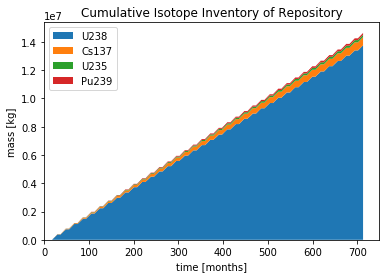

In [20]:
analysis.plot_in_flux_cumulative(cur, 'NuclearRepository','Cumulative Isotope Inventory of Repository')

Now let's plot the cumulative mass of the spent nuclear fuel that is mined from the Uranium mine
To plot the outflux of a facility, use the analysis.plot_out_flux_cumulative(cur,sender,plot title) function.

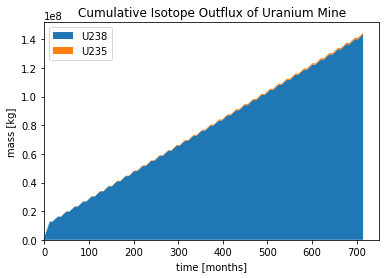

In [21]:
analysis.plot_out_flux_cumulative(cur, 'UraniumMine','Cumulative Isotope Outflux of Uranium Mine')


Now let's plot the cumulative mass of the spent nuclear fuel that is taken out of the 1000MWe Honeycomb3000.
Again, let's use the handy analysis.plot_out_flux_cumulative(cur,sender,plot title) function!

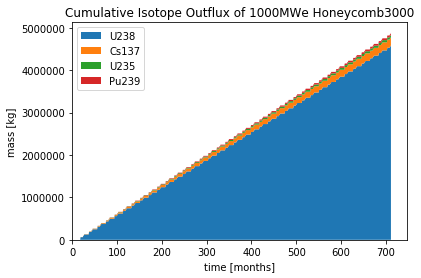

In [22]:
analysis.plot_out_flux_cumulative(cur, '1000MWe Honeycomb3000','Cumulative Isotope Outflux of 1000MWe Honeycomb3000')

Now let's plot the mass series and cumulative mass of the fresh nuclear fuel that is received by the of the 1000MWe Honeycomb3000.

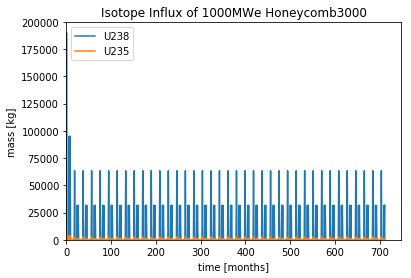

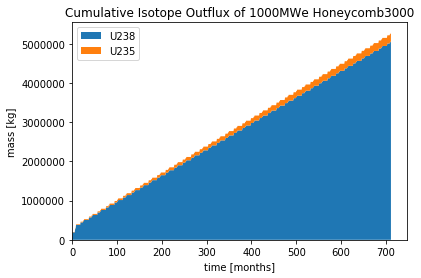

In [23]:
analysis.plot_in_flux_basic(cur, '1000MWe Honeycomb3000','Isotope Influx of 1000MWe Honeycomb3000')
analysis.plot_in_flux_cumulative(cur, '1000MWe Honeycomb3000','Cumulative Isotope Outflux of 1000MWe Honeycomb3000')

In cyclus, facilities are defined by their `prototype_id`. For example if the simualtion had 20 Honeycomb3000 reactors, we could still find a certain one via its `prototype_id`.

In [24]:
analysis.prototype_id(cur, 'UraniumMine')

['52', '57']

In [25]:
analysis.total_isotope_used(cur, 'UraniumMine')

{'U235': 1028095.6204379612, 'U238': 143570444.52554709}

After reading and understanding the general structure of the *CYCLUS* output file and how to index within an sql file, you should be able to pull desired data in ways beyond the functions in this tutorial.

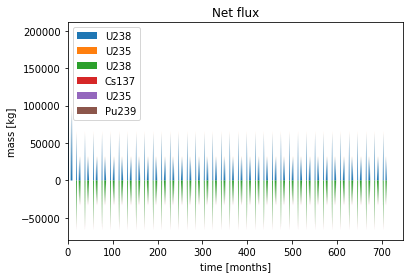

In [26]:
analysis.plot_net_flux(cur,'1000MWe Honeycomb3000','Net flux')


In [27]:
analysis.u_util_calc(cur)

The Average Fuel Utilization Factor is: 
0.0177723910034


array([ 0.        ,  0.11108108,  0.05554054,  0.07405405,  0.05554054,
        0.06664865,  0.05554054,  0.0634749 ,  0.05554054,  0.06171171,
        0.05554054,  0.06058968,  0.05554054,  0.05126819,  0.04760618,
        0.04443243,  0.04165541,  0.03920509,  0.03702703,  0.0373547 ,
        0.03577187,  0.03612393,  0.03471284,  0.03507824,  0.03380729,
        0.03417879,  0.03302411,  0.03339693,  0.03234006,  0.03271099,
        0.03173745,  0.03082018,  0.02995445,  0.02913602,  0.02836113,
        0.02762638,  0.02692875,  0.02626548,  0.02670218,  0.02607537,
        0.0264964 ,  0.02590231,  0.02630868,  0.02574411,  0.02613672,
        0.02559893,  0.02597864,  0.02546523,  0.02583281,  0.02534169,
        0.0248689 ,  0.02441342,  0.02397433,  0.02355076,  0.02314189,
        0.02274698,  0.02236532,  0.02272946,  0.02236048,  0.02271306,
        0.02235594,  0.02269768,  0.02235168,  0.02268322,  0.02234767,
        0.02266961,  0.0223439 ,  0.02265676,  0.02234033,  0.02

The Average Fuel Utilization Factor is: 
0.0177723910034


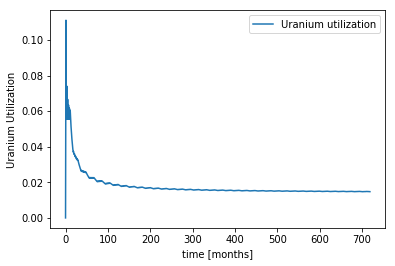

In [28]:
analysis.plot_uranium_utilization(cur)
